# 환경 세팅

In [1]:
import os
import torch
import utils
import modeling_finetune
import json
import cv2
import matplotlib.pyplot as plt
import pandas as pd    
from custom_dataset import CustomVQATestDataset
from timm.models import create_model
from torch.utils.data import DataLoader
from tqdm.auto import tqdm


current_path = os.getcwd()
custom_dataset_path = os.path.join(current_path, 'custom_dataset')
json_path = os.path.join(custom_dataset_path, 'custom.vqa.test.jsonl')
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

print(f'CUDA Available: {torch.cuda.is_available()}')

c:\Users\joony\mambaforge\envs\BEiT-3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA Available: True


# 데이터세트 준비

In [2]:
test_dataset = CustomVQATestDataset(img_size=768)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8)

# 모델 불러오기

In [6]:
model_config = 'beit3_large_patch16_768_vqav2'
model = create_model(
    model_config,
    pretrained=False,
    drop_path_rate=0.1,
    vocab_size=64010
)

utils.load_model_and_may_interpolate(
    ckpt_path=os.path.join(current_path, 'model', 'beit3_large_indomain_patch16_768_vgqaaug_vqa.zip'),
    model=model,
    model_key='model|module',
    model_prefix=''
)

model.eval()
model.to(device)

Load ckpt from d:\Codes\python_projects_windows\VQA\BEiT-3\unilm\beit3\model\beit3_large_indomain_patch16_768_vgqaaug_vqa.zip
Load state_dict by model_key = model


BEiT3ForVisualQuestionAnswering(
  (beit3): BEiT3(
    (text_embed): TextEmbedding(64010, 1024)
    (vision_embed): VisionEmbedding(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): Encoder(
      (dropout_module): Dropout(p=0.0, inplace=False)
      (embed_positions): MutliwayEmbedding(
        (A): PositionalEmbedding(2307, 1024)
        (B): PositionalEmbedding(1024, 1024)
      )
      (layers): ModuleList(
        (0): EncoderLayer(
          (self_attn): MultiheadAttention(
            (k_proj): MultiwayNetwork(
              (A): Linear(in_features=1024, out_features=1024, bias=True)
              (B): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (v_proj): MultiwayNetwork(
              (A): Linear(in_features=1024, out_features=1024, bias=True)
              (B): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (q_proj): MultiwayNetwork(
              (A): Linear(in_feat

# 추론

In [4]:
preds = []
with torch.no_grad():
    for data in tqdm(test_loader, total=len(test_loader)):
        images = data['image'].to(device)
        question = data['question'].to(device)
        padding_mask = data['padding_mask'].to(device)

        outputs = model(images, question, padding_mask)

        _, pred = outputs.max(-1)
        for x in pred:
            preds.append(test_dataset.label2ans[x])


100%|██████████| 1/1 [01:23<00:00, 83.60s/it]


결과 시각화

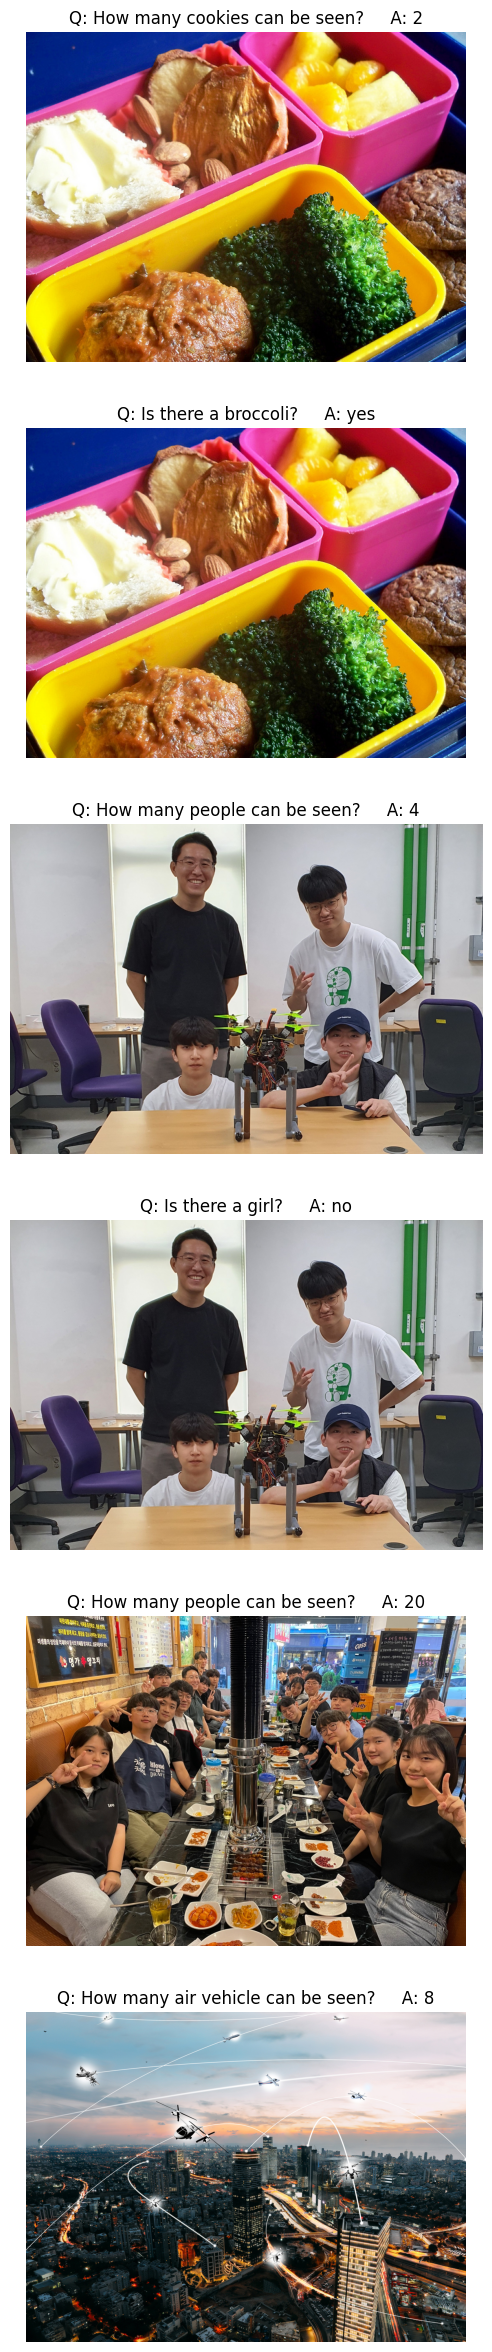

In [5]:
test_df = pd.read_json(path_or_buf=json_path, lines=True)

plt.figure(figsize=(40, 30))


for idx in range(len(test_df)):
    img = cv2.imread(os.path.join(custom_dataset_path,test_df.iloc[idx]["image_path"]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(len(test_df),1,idx+1)
    plt.imshow(img)
    plt.title(f'Q: {test_df.iloc[idx]["question"]}     A: {preds[idx]}')
    plt.axis('off')

